<h1 style="font-size:400%">Clothing classifier</h1>

This notebook is a demonstration of using [PyTorch Lightning](https://lightning.ai/pytorch-lightning) and transfer learning to fine tune a pretrained model for image classification to classify images of attire. We use a subset of the [Clothing Dataset](https://github.com/alexeygrigorev/clothing-dataset) by Alexey Grigorev. The data for this example is included in the git repo, so you can just clone this repo and run the notebook.

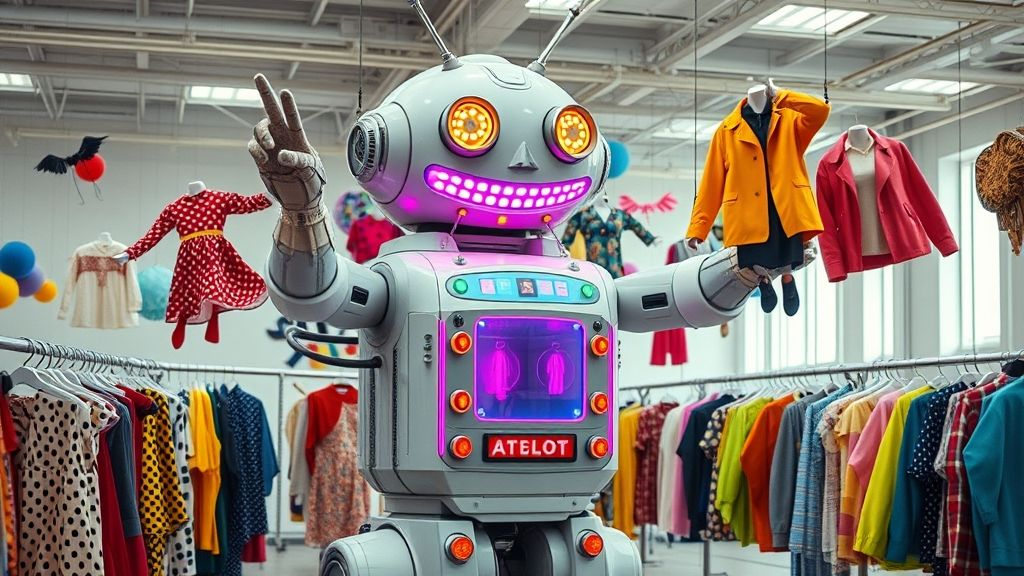

In [1]:
import os, pandas, platform, torch, torchvision, pytorch_lightning

torch.manual_seed(42)

data_path = "dataset/data"
inference_path = "dataset/inference"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", torchvision.__version__, "| pytorch_lightning", pytorch_lightning.__version__, "| pandas", pandas.__version__)

Versions: python 3.13.2 | torch 2.6.0+cpu | torchvision 0.21.0+cpu | pytorch_lightning 2.5.0.post0 | pandas 2.2.3


# Loading a pre-trained model

Because this notebook uses transfer learning we therefore need to load a pretrained model to fine tune. In this case we go for [ResNet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) which is a relatively simple vision model for classification tasks. Of course it is always possible to load a deeper model with the intention to get better results, but if we can solve a problem with a simpler solution that is often the better choice. So, start with a simpeler model first.

In [2]:
from torchvision import models

pretrained_model = models.resnet18(weights="DEFAULT")

# Preprocessing

The ResNet models are all pretrained on the ImageNet dataset, containing images of size 244 x 244 pixels. Consequently, in order to fine-tune this pretrained model we need to ensure that our input images are of the same size. To this purpose we prepare a transform here. The transform can accept loaded images, resize them and output a tensor for input to the model.

In [3]:
from torchvision import transforms

image_size = (244, 244)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

## Create a dataset

Here we extend the LightningDataModule to load the image data from disk and offer the verious loaders that we need later.

In [4]:
from pytorch_lightning import LightningDataModule
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

class ImageFolderDataSet(LightningDataModule):
    def __init__(self, path, transform, split=[.7, .2, .1], batch_size=32, num_workers=int(os.cpu_count()/2)):
        super().__init__()
        self.path = path
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.data = ImageFolder(self.path, transform=self.transform)
        self.train, self.val, self.test = random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def classes(self):
        return self.data.classes



dataset = ImageFolderDataSet(data_path, transform)
dataset.setup()
classes = dataset.classes()
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


## Create a model

A LightningModule is extended to load the pretrained model that we downloaded before, and allow it to be fine-tuned. We include the common metrics Accuracy, Precision and Recall. It is possible to tine-tune all the layers in the model or keep all layers except the final decision frozen.

In [5]:
from pytorch_lightning import LightningModule
from torch import nn
from torchmetrics import Accuracy, Precision, Recall

class ImageClassifierModel(LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters(): 
                param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = Recall(task="multiclass", num_classes=self.num_classes, average="none") 
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.002) 

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.criterion(logits, y))

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])


model = ImageClassifierModel(pretrained_model, num_classes=len(classes))

# Train

Use the PyTorch Lightning Trainer to train the model.

In [6]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

logger = CSVLogger(save_dir=".")
trainer = Trainer(max_epochs=-1, logger=logger, callbacks=[EarlyStopping(monitor="val_loss")])
trainer.fit(model, datamodule=dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Epoch 13: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s, v_num=12]        


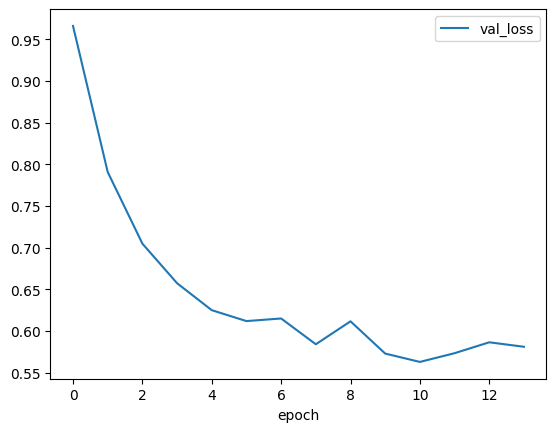

In [7]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

## Test

Let's report the metrics.

In [8]:
scores = trainer.test(model, datamodule=dataset, verbose=False)
accuracies = [scores[0]["test_accuracy_class_" + str(i)] for i in range(len(classes))]
precisions = [scores[0]["test_precision_class_" + str(i)] for i in range(len(classes))]
recalls = [scores[0]["test_recall_class_" + str(i)] for i in range(len(classes))]
df = pandas.DataFrame({"class": classes, "accuracy": accuracies, "precision": precisions, "recall": recalls}).set_index("class")
df

Testing DataLoader 0: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


,accuracy,precision,recall
class,,,
dress,0.695652,0.842105,0.695652
hat,0.875000,0.933333,0.875000
longsleeve,0.759259,0.854167,0.759259
outwear,0.625000,1.000000,0.625000
pants,0.921569,0.959184,0.921569
shirt,0.866667,0.742857,0.866667
shoes,0.972222,0.972222,0.972222
shorts,0.769231,0.800000,0.769231
skirt,0.777778,0.538462,0.777778


## Inference

And now run inference on the inference images.

In [9]:
inference_folder = ImageFolder(inference_path, transform=transform)
inference_dataloader = DataLoader(inference_folder, batch_size=32, num_workers=int(os.cpu_count()/2), persistent_workers=True)
preds = trainer.predict(model, dataloaders=inference_dataloader)
predictions = torch.cat(preds)
images = torch.cat([x for x, y in inference_dataloader])
labels = torch.cat([y for x, y in inference_dataloader])

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


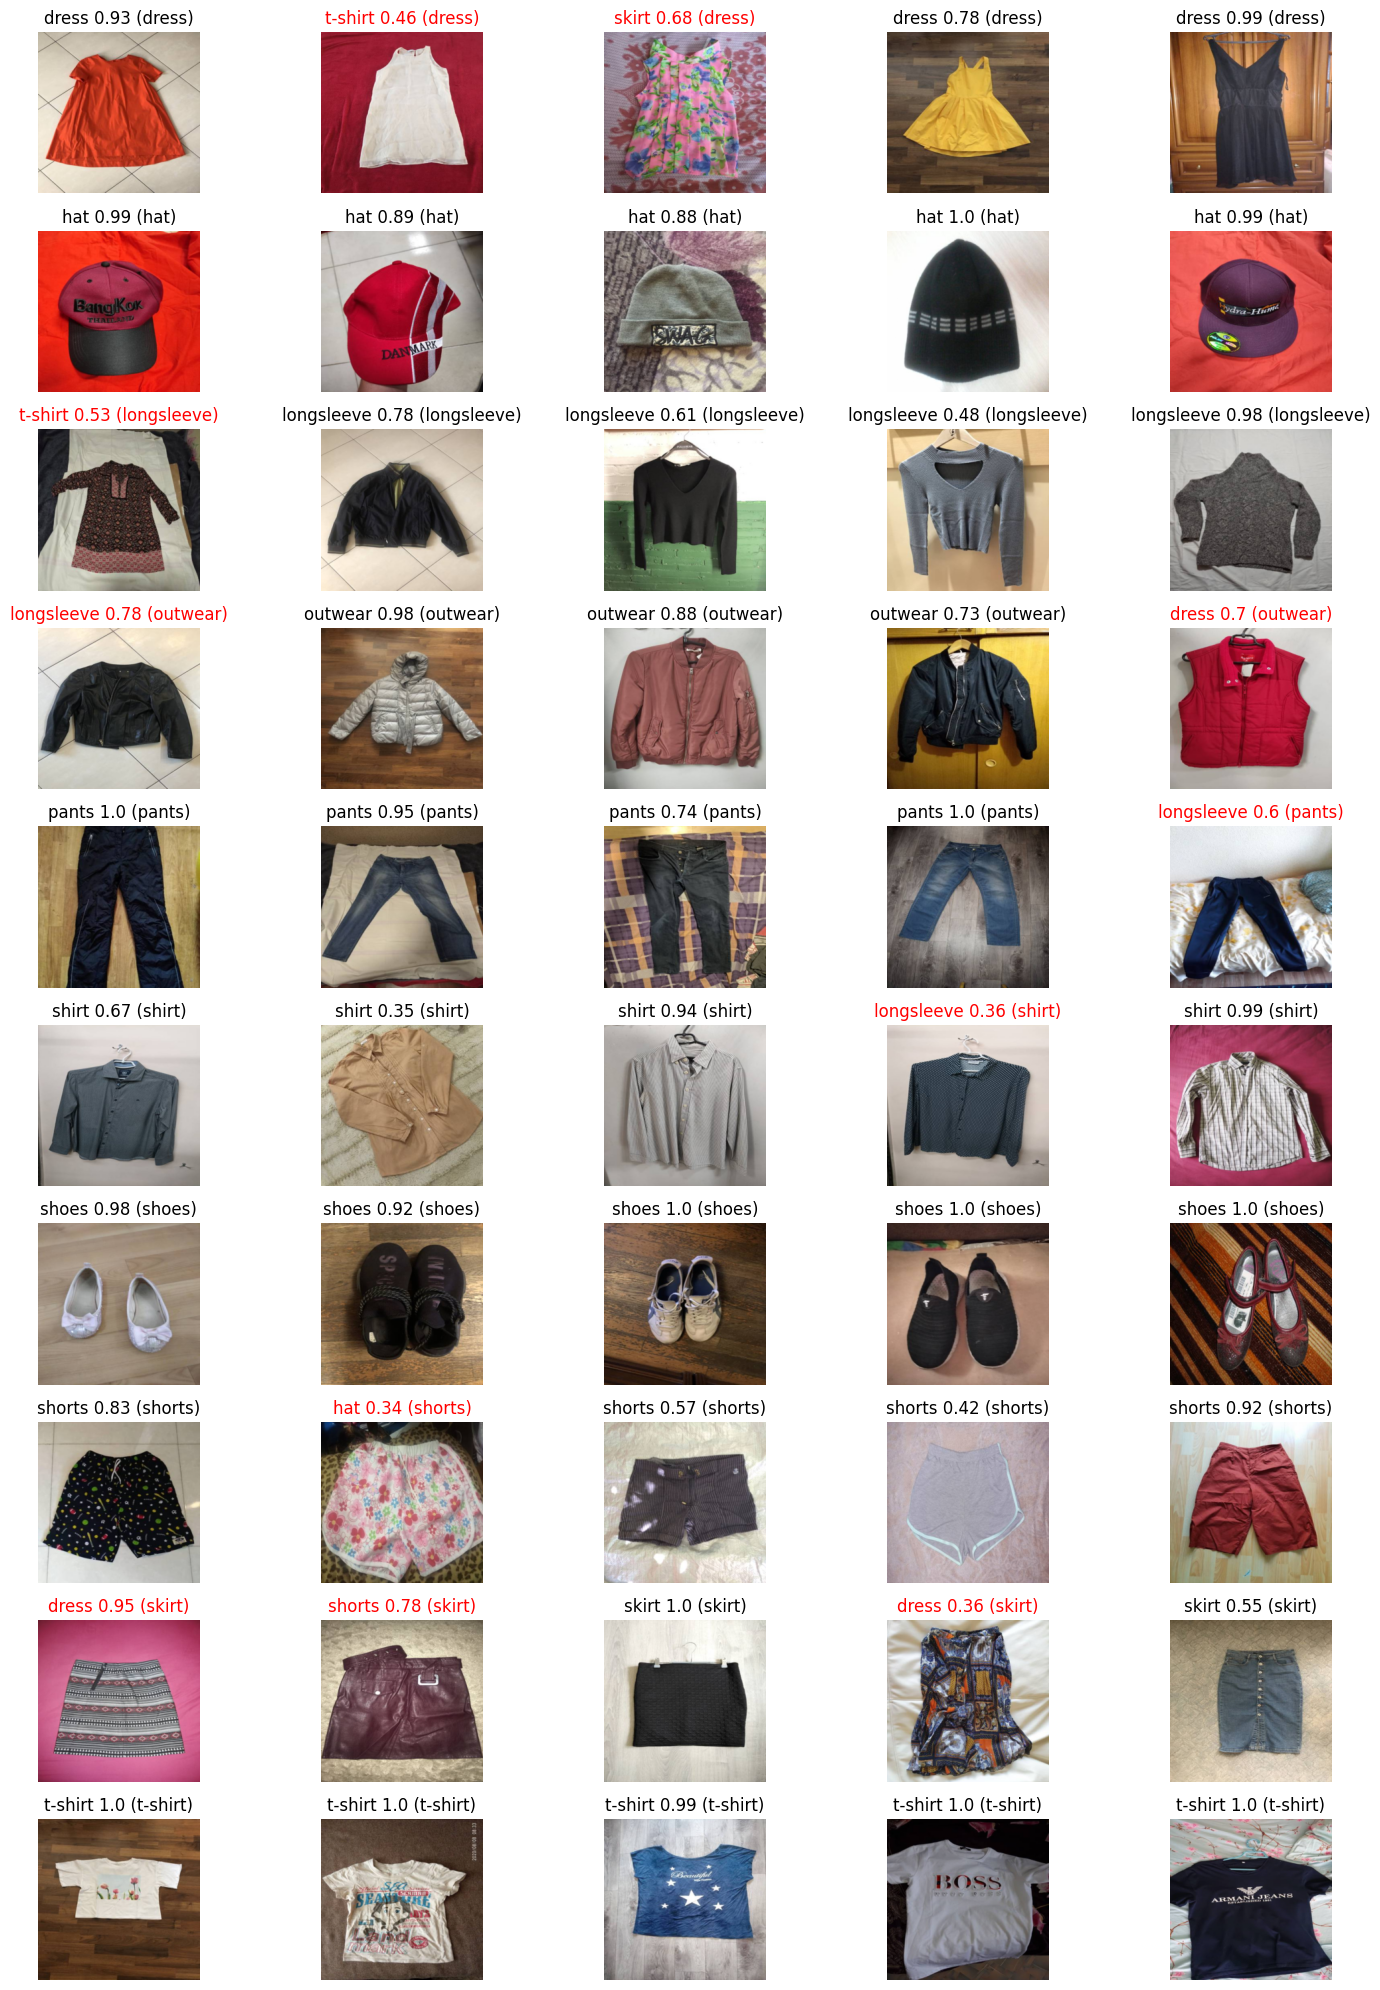

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    probabilities = torch.softmax(prediction, dim=0)
    pred_class = torch.argmax(probabilities)
    pred_prob = probabilities[pred_class].item()
    pred_label = classes[pred_class]
    truth_label = classes[truth.item()]
    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_title(pred_label + " " + str(round(pred_prob,2)) + " ("+ truth_label+")", color="red" if pred_label != truth_label else "black")
    axs[i].axis("off")
plt.tight_layout()
plt.show()